# LIGO Sensitivities

Here, we estimate the LIGO sensitivities as a function of redshift

**References:** [arXiv:1602.03842](https://arxiv.org/pdf/1602.03842.pdf), [arXiv:1606.03939](https://arxiv.org/abs/1606.03939), [arXiv:1704.04628](https://arxiv.org/abs/1704.04628)

In [3]:
%matplotlib inline

from __future__ import division

import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl

#----- MATPLOTLIB paramaters ---------
mpl.rcParams.update({'font.size': 18,'font.family':'serif'})

mpl.rcParams['xtick.major.size'] = 7
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 7
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['ytick.minor.width'] = 1
#--------------------------------------

from scipy.interpolate import interp1d
from scipy.integrate import quad


### LIGO sensitivity as a function of redshift

Read in the time-volume sensitivity for LIGO, from Fig. 7 of [arXiv:1704.04628](https://arxiv.org/abs/1704.04628):

In [4]:
sens_data_10Msun = np.loadtxt("../data/LIGO_sensitivity_10.txt")
sens_data_20Msun = np.loadtxt("../data/LIGO_sensitivity_20.txt")
sens_data_40Msun = np.loadtxt("../data/LIGO_sensitivity_40.txt")

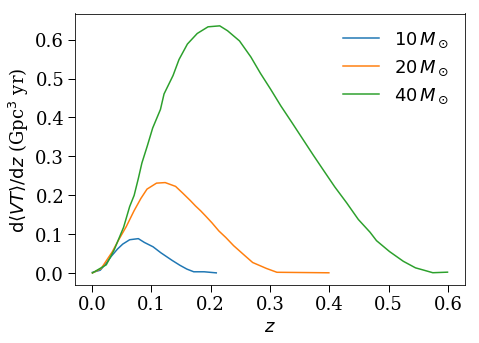

In [5]:

sensitivities = [sens_data_10Msun, sens_data_20Msun, sens_data_40Msun]
labels = [r"$10\,M_\odot$",r"$20\,M_\odot$",r"$40\,M_\odot$"]

pl.figure(figsize=(7,5))

for sens, lab in zip(sensitivities, labels):
    pl.plot(sens[:,0], sens[:,1], linewidth=1.5, label=lab)
    
#pl.xlim(0, 1.0)
#pl.ylim(0, 0.75)

pl.xlabel(r"$z$")
pl.ylabel(r"$\mathrm{d}\langle V T \rangle/\mathrm{d}z$ (Gpc$^3$ yr)")

pl.legend(loc='upper right', frameon=False)

pl.show()

### Calculating the LIGO sensitivity

Unfortunately, we don't have sensitivity information as a function of redshift for any other PBH masses. However, the distribution of merger times turns out to be more or less uniform as a function of $t$ (and therefore $z$). We therefore only need the integrated time-volume sensitivity $\langle VT \rangle$.

We obtain this by integrating the above sensitivities as a function of redshift. For 100, 200 and 300 Solar Mass BHs, we take the 90% upper limit on the merger rate density from [arXiv:1704.04628](https://arxiv.org/abs/1704.04628). We can convert between time-volume and sensitivity using:

$$R_{90\%} = \frac{2.303}{\langle VT \rangle} \, ,$$

from Eq. 2 of that paper.

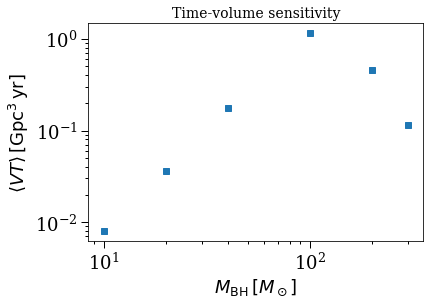

In [8]:
M_list = np.asarray([10., 20., 40.])
VT = np.zeros_like(M_list)

#Calculate stellar mass BH sensitivities by integrating
for i, sens in enumerate(sensitivities):
    VT[i] = np.trapz(sens[:,1], sens[:,0])

#Calculate IMBH sensitivities by converting from R90    
R_90_IMBH = np.loadtxt("../data/LIGO_R90_IMBH.txt")
M_list = np.append(M_list, R_90_IMBH[:,0])
VT_IMBH = np.asarray([2.303/R_90_IMBH[j,1] for j in range(3)]) 

VT = np.append(VT, VT_IMBH)

#Do some plotting
pl.figure()
pl.loglog(M_list, VT, 's')
pl.xlabel(r"$M_\mathrm{BH} \,[M_\odot]$")
pl.ylabel(r"$\langle VT \rangle \, [\mathrm{Gpc}^3 \,\mathrm{yr}]$")
pl.title("Time-volume sensitivity", fontsize=14.0)
pl.show()

### LIGO Upper limit

Estimate the LIGO upper limit on the merger rate density and save to file

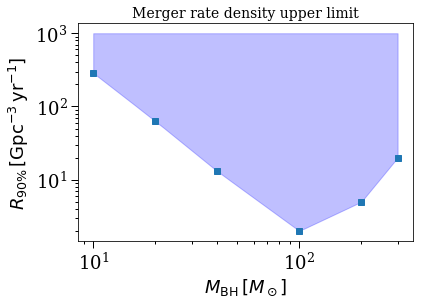

In [9]:
R90_LIGO = 2.303/VT

np.savetxt("../data/R90_LIGO.txt", zip(M_list, R90_LIGO), header="90% UL on merger rate density from LIGO\nColumns: M_BH [M_solar], R_90% [Gpc^-3 yr^-1]")

M1 = np.linspace(M_list[0], M_list[-1])

lR90_interp = interp1d(np.log10(M_list), np.log10(R90_LIGO), kind='linear')

pl.figure()
pl.fill_between(M1, 10**lR90_interp(np.log10(M1)), 1e3, color='blue', alpha=0.25)
pl.loglog(M_list, R90_LIGO, 's')
pl.xlabel(r"$M_\mathrm{BH} \,[M_\odot]$")
pl.ylabel(r"$R_{90\%} \, [\mathrm{Gpc}^{-3} \,\mathrm{yr}^{-1}]$")
pl.title("Merger rate density upper limit", fontsize=14.0)
pl.show()

### Estimating the LIGO sensitivity for 100, 200 and 300 solar masses

#### Redshift-time relation

The time since the Big Bang is given by:

$$t(z) = \int_z^\infty \frac{\mathrm{d}z'}{(1+z') H(z')}\,,$$

where

$$H(z') = \sqrt{\Omega_\Lambda + \Omega_m (1+z)^3}\,,$$

in a flat universe. We use the Planck 2015 values from [arXiv:1502.01589](https://arxiv.org/abs/1502.01589), noting that there is some tension between different measurements of $H_0$:

- $H_0 = 67.8 \,\,\mathrm{km/s}\,\mathrm{Mpc}^{-1}$
- $\Omega_\Lambda = 0.692$
- $\Omega_m = 0.308$

In [11]:
#Get H in units of 1/yr
#(km/Mpc) = 3.24e-20
H0_peryr = 67.8*(3.24e-20)*(60*60*24*365)

Omega_L = 0.692
Omega_m = 0.308

def Hubble(z):
    return H0_peryr*np.sqrt(Omega_L + Omega_m*(1+z)**3)

In [15]:
#Calculate time from Big Bang until redshift z (in years)
def t_univ(z):
    integ = lambda x: 1.0/((1+x)*Hubble(x))
    return quad(integ, z, np.inf)[0]

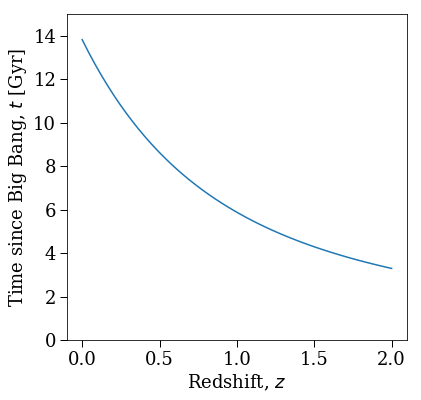

In [16]:
#Plot age of the universe as a function of Redshift

zlist = np.linspace(0, 2, 50)
tvals = np.asarray([t_univ(z) for z in zlist])

pl.figure(figsize=(6.1,6))
pl.plot(zlist, tvals/1e9)

pl.xlabel(r"Redshift, $z$")
pl.ylabel(r"Time since Big Bang, $t$ [Gyr]")

pl.ylim(0, 15)

pl.show()

z_of_t = interp1d(tvals, zlist)

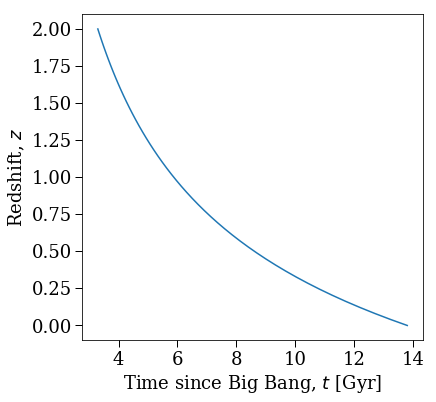

In [18]:
#Now also plot z as a function of time

pl.figure(figsize=(6.1,6))
pl.plot(tvals/1e9,zlist)

pl.ylabel(r"Redshift, $z$")
pl.xlabel(r"Time since Big Bang, $t$ [Gyr]")

pl.show()

### Luminosity distance

In [19]:
def calcdL(z):
    c = 3.06594845e-7
    return c*(1+z)*quad(lambda x: Hubble(x)**-1, 0, z)[0]

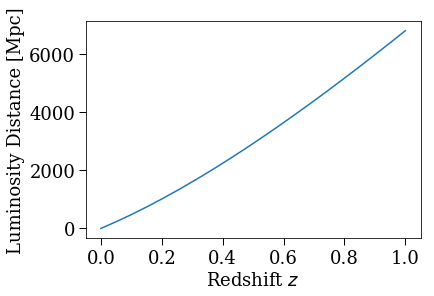

In [20]:
z_list = np.linspace(0, 1, 20)

dL_list = np.asarray([calcdL(z) for z in z_list])

z_of_dL = interp1d(dL_list, z_list)

pl.figure()
pl.plot(z_list, dL_list)
pl.xlabel(r"Redshift $z$")
pl.ylabel(r"Luminosity Distance [Mpc]")

pl.show()

### Horizon distance and redshift

Read in data for the LIGO horizon distance ([arXiv:1704.04628](https://arxiv.org/abs/1704.04628))

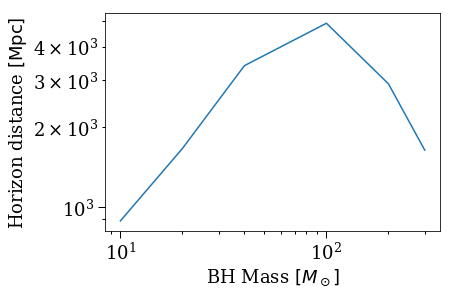

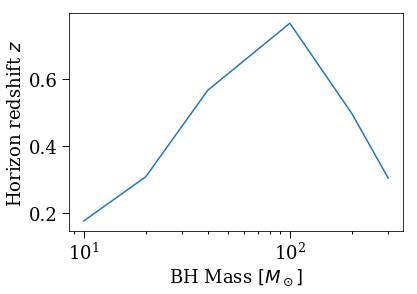

In [22]:
horizon_data = np.loadtxt("../data/LIGO_Horizon.txt")
MBH_list = horizon_data[:,0]/2.0
horizon_list = horizon_data[:,1]

horizon_interp = interp1d(MBH_list, horizon_list)

M_vals = np.logspace(np.log10(5), np.log10(500))

pl.figure()
pl.loglog(M_list, horizon_interp(M_list))
pl.xlabel(r'BH Mass $[M_\odot]$')
pl.ylabel(r'Horizon distance $[\mathrm{Mpc}]$')

pl.show()

#Now plot horizon redshift as a function of M_BH

pl.figure()
pl.semilogx(M_list, z_of_dL(horizon_interp(M_list)))
pl.xlabel(r'BH Mass $[M_\odot]$')
pl.ylabel(r'Horizon redshift $z$')

pl.show()


### Correcting the sensitivity curves

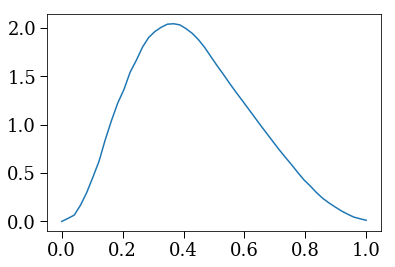

In [23]:
z_max_40 = z_of_dL(horizon_interp(40.0))
norm_40 = np.trapz(sens_data_40Msun[:,1], sens_data_40Msun[:,0])

sens_generic = interp1d(sens_data_40Msun[:,0]/z_max_40, z_max_40*sens_data_40Msun[:,1]/norm_40, bounds_error=False, fill_value = 0.0)

def sens_curve(z, M_BH):
    z_max = z_of_dL(horizon_interp(M_BH))
    return sens_generic(z/z_max)/z_max

xvals = np.linspace(0, 1)

pl.figure()
pl.plot(xvals, sens_generic(xvals))
pl.show()


### Plotting the various sensitivity curves and saving to file

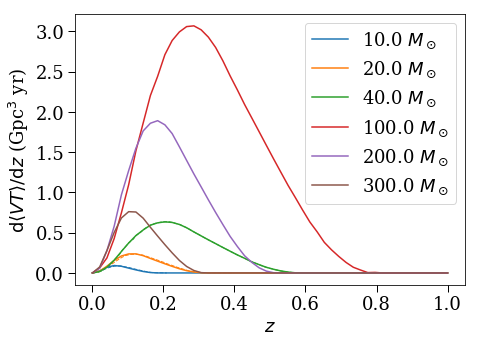

In [26]:
zvals = np.linspace(0, 1.0, 50)

new_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b']#, '#e377c2', '#7f7f7f',
              #'#bcbd22', '#17becf']

pl.figure(figsize=(7,5))


for sens, lab, col in zip(sensitivities, labels, new_colors):
    pl.plot(sens[:,0], sens[:,1], linestyle='--', linewidth=1.0, color=col)

for i in range(6):
    pl.plot(zvals, VT[i]*sens_curve(zvals, M_list[i]), label=str(M_list[i]) + " $M_\odot$", color=new_colors[i])
    
    
pl.xlabel(r"$z$")
pl.ylabel(r"$\mathrm{d}\langle V T \rangle/\mathrm{d}z$ (Gpc$^3$ yr)")

pl.legend()
pl.savefig("../plots/LIGO_sensitivity.pdf")
pl.show()

np.savetxt("../data/LIGO_sensitivity_100.txt", zip(zvals, VT[3]*sens_curve(zvals, M_list[3])))
np.savetxt("../data/LIGO_sensitivity_200.txt", zip(zvals, VT[4]*sens_curve(zvals, M_list[3])))
np.savetxt("../data/LIGO_sensitivity_300.txt", zip(zvals, VT[5]*sens_curve(zvals, M_list[3])))
